In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
insurance_data = pd.read_csv("/Users/avanthpakanati/Desktop/ECON:HLTH Research Seminar /Homework5/data/Output/acs_insurance.txt", sep="\t")
expansion_data = pd.read_csv("/Users/avanthpakanati/Desktop/ECON:HLTH Research Seminar /Homework5/data/Output/medicaid_expansion.txt", sep="\t")
medicaid_data = pd.read_csv("/Users/avanthpakanati/Desktop/ECON:HLTH Research Seminar /Homework5/data/Output/acs_medicaid.txt", sep="\t")



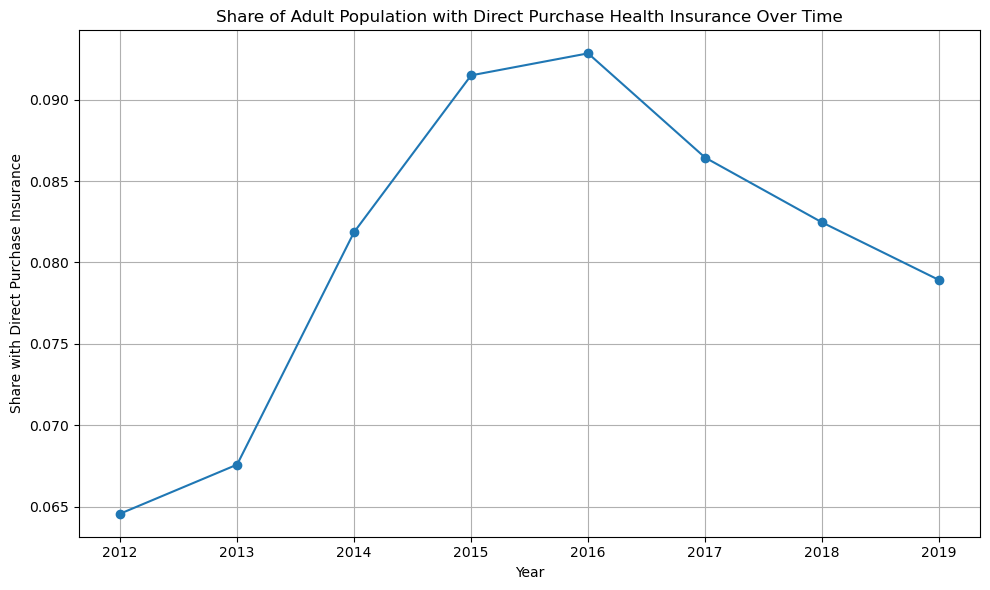

In [3]:

#Question 1 

# Calculate the share of adults with direct purchase insurance
insurance_data['direct_share'] = insurance_data['ins_direct'] / insurance_data['adult_pop']

# Group by year and sum across all states
national_share = insurance_data.groupby('year')[['ins_direct', 'adult_pop']].sum()

# Calculate national share of direct purchase insurance
national_share['direct_share'] = national_share['ins_direct'] / national_share['adult_pop']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(national_share.index, national_share['direct_share'], marker='o')
plt.title('Share of Adult Population with Direct Purchase Health Insurance Over Time')
plt.xlabel('Year')
plt.ylabel('Share with Direct Purchase Insurance')
plt.grid(True)
plt.tight_layout()
plt.show()





#Question 2
Originally went up due to ACA, but several policy changes caused it to decline 

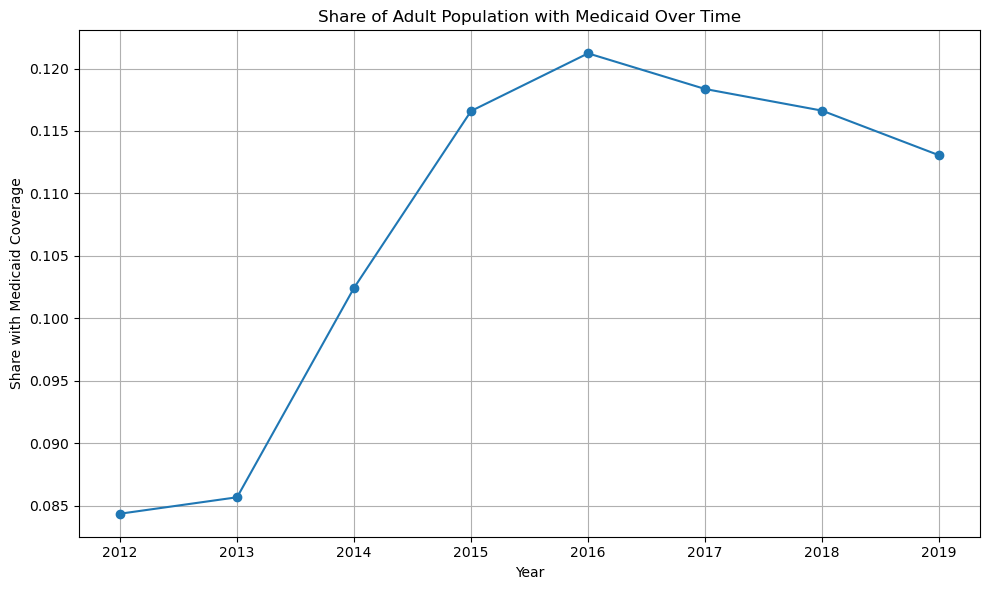

In [4]:
#Question 3 

insurance_data['medicaid_share'] = insurance_data['ins_medicaid'] / insurance_data['adult_pop']
medicaid_national_share = insurance_data.groupby('year')[['ins_medicaid', 'adult_pop']].sum()

medicaid_national_share['medicaid_share'] = medicaid_national_share['ins_medicaid'] / medicaid_national_share['adult_pop']

medicaid_national_share = insurance_data.groupby('year')[['ins_medicaid', 'adult_pop']].sum()

medicaid_national_share['medicaid_share'] = medicaid_national_share['ins_medicaid'] / medicaid_national_share['adult_pop']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(medicaid_national_share.index, medicaid_national_share['medicaid_share'], marker='o', linestyle='-')
plt.title('Share of Adult Population with Medicaid Over Time')
plt.xlabel('Year')
plt.ylabel('Share with Medicaid Coverage')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1013151488.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expansion_data_clean['expanded_2014'] = expansion_data_clean['expand_year'] <= 2014


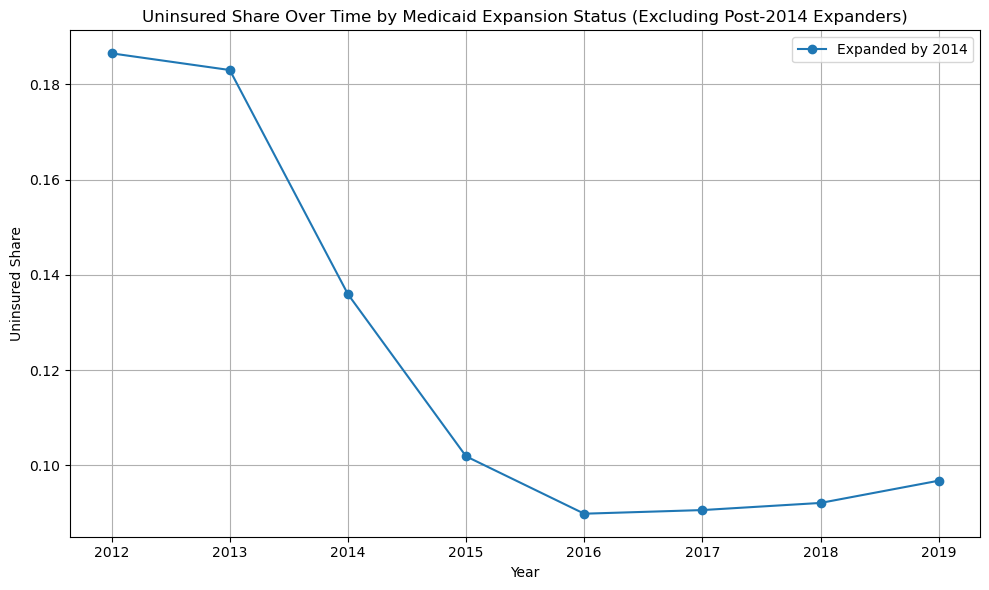

In [5]:
#Question 4
expansion_data['date_adopted'] = pd.to_datetime(expansion_data['date_adopted'], errors='coerce')
expansion_data['expand_year'] = expansion_data['date_adopted'].dt.year
expansion_data_clean = expansion_data[expansion_data['expand_year'] <= 2014]

expansion_data_clean['expanded_2014'] = expansion_data_clean['expand_year'] <= 2014

merged_data = pd.merge(insurance_data, expansion_data_clean[['State', 'expanded_2014']], on='State', how='inner')

merged_data['uninsured_share'] = merged_data['uninsured'] / merged_data['adult_pop']

# Group by year and expansion status, then aggregate
grouped = merged_data.groupby(['year', 'expanded_2014'])[['uninsured', 'adult_pop']].sum()
grouped['uninsured_share'] = grouped['uninsured'] / grouped['adult_pop']
grouped = grouped.reset_index()

# Plotting
plt.figure(figsize=(10, 6))
for label, df in grouped.groupby('expanded_2014'):
    label_str = 'Expanded by 2014' if label else 'Not Expanded by 2014'
    plt.plot(df['year'], df['uninsured_share'], marker='o', label=label_str)

plt.title('Uninsured Share Over Time by Medicaid Expansion Status (Excluding Post-2014 Expanders)')
plt.xlabel('Year')
plt.ylabel('Uninsured Share')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
#Question 5


#filter for years 2012 and 2015 
filtered_medicaid = medicaid_data[medicaid_data['year'].isin([2012, 2015])]

expansion = filtered_medicaid.loc[filtered_medicaid['expand_year'] <= 2014, 'State'].unique()
non_expansion = filtered_medicaid.loc[filtered_medicaid['expand_ever'] == False, 'State'].unique()


final_data = filtered_medicaid[filtered_medicaid['State'].isin(list(expansion) + list(non_expansion))]


# Calculate uninsured share
final_data['uninsured_share'] = final_data['uninsured'] / final_data['adult_pop']

grouped = final_data.groupby(['year', 'expand_ever'])['uninsured_share'].mean().reset_index()

# Pivot to create the 2x2 DiD table
dd_table = grouped.pivot(index='expand_ever', columns='year', values='uninsured_share')
dd_table.index = ['Non-Expansion States', 'Expansion States']

# Display the table
print(dd_table)




year                      2012      2015
Non-Expansion States  0.215653  0.158208
Expansion States      0.168052  0.094090


/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/2992481859.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['uninsured_share'] = final_data['uninsured'] / final_data['adult_pop']


In [7]:
#Question 6
final_data['D'] = final_data['expand_ever'].astype(int)
final_data['Post'] = (final_data['year'] == 2015).astype(int)

# Run Difference-in-Differences regression
model = smf.ols('uninsured_share ~ D + Post + D:Post', data=final_data).fit()
model_summary = model.summary()

model_summary

/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1486860411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['D'] = final_data['expand_ever'].astype(int)
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1486860411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Post'] = (final_data['year'] == 2015).astype(int)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        uninsured_share   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     26.55
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           3.55e-12
Time:                        09:39:14   Log-Likelihood:                 148.55
No. Observations:                  88   AIC:                            -289.1
Df Residuals:                      84   BIC:                            -279.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2157      0.011     19.420      0.000       0.194       0.238
D             -0.0476      0.014     -3.358      0.001      -0.076      -0.019
Post          -0.0574      0.016     -3.658      0.000      -0.089      -0.026
D:Post        -0.0165      0.020     -0.824      0.412      -0.056       0.023
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.265
Skew:                           0.134   Prob(JB):                        0.876
Kurtosis:                       3.017   Cond. No.                         7.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
#Question 7

final_data['D'] = final_data['expand_ever'].astype(int)
final_data['Post'] = (final_data['year'] == 2015).astype(int)

# Calculate uninsured share
final_data['uninsured_share'] = final_data['uninsured'] / final_df['adult_pop']

final_df = final_data.set_index(['State', 'year'])

# Run the DiD regression with state and year fixed effects
model = PanelOLS.from_formula('uninsured_share ~ D*Post + EntityEffects + TimeEffects', data=final_df).fit()


/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1903189088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['D'] = final_data['expand_ever'].astype(int)
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1903189088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Post'] = (final_data['year'] == 2015).astype(int)


NameError: name 'final_df' is not defined

In [9]:
#Question 8
# Filter for the years 2012 and 2015 (including all states)
filtered_df = medicaid_data[medicaid_data['year'].isin([2012, 2015])]

# Create treatment indicator (D) for any state that ever expanded Medicaid
filtered_df['D'] = filtered_df['expand_ever'].astype(int)

# Create post-period indicator (Post) for 2015
filtered_df['Post'] = (filtered_df['year'] == 2015).astype(int)

# Calculate the uninsured share
filtered_df['uninsured_share'] = filtered_df['uninsured'] / filtered_df['adult_pop']

# Run Difference-in-Differences regression including all states
model_all_states = smf.ols('uninsured_share ~ D + Post + D:Post', data=filtered_df).fit()

# Show the regression summary
print(model_all_states.summary())

ValueError: cannot convert float NaN to integer

In [12]:
#Question 9

final_data.loc[final_data['expand_ever'] == False, 'event_time'] = -99

for yr in range(-2, 4):  # event window from -2 to +3 years
    if yr != -1:  # omit -1 as base year
        final_data[f'event_{yr}'] = (final_data['event_time'] == yr).astype(int)

final_data['uninsured_share'] = final_data['uninsured'] / final_data['adult_pop']

# Run regression with event dummies, state fixed effects, and year fixed effects
event_dummies = ' + '.join([f'event_{yr}' for yr in range(-2, 4) if yr != -1])
formula = f'uninsured_share ~ {event_dummies} + C(State) + C(year)'
model = smf.ols(formula, data=final_data).fit()


/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1343767846.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[f'event_{yr}'] = (final_data['event_time'] == yr).astype(int)
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1343767846.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[f'event_{yr}'] = (final_data['event_time'] == yr).astype(int)
/var/folders/2q/wzjp_2kd355b8clhzqwmytb40000gn/T/ipykernel_44777/1343767846.py:7: SettingWithCopyWarning: 
A v

PatsyError: numbers besides '0' and '1' are only allowed with **
    uninsured_share ~ event_-2 + event_0 + event_1 + event_2 + event_3 + C(State) + C(year)
                             ^

In [ ]:
#Question 10 

